# Computational Set 2: Entangling Operations through strong light-matter coupling
[Jay Foley, University of North Carolina Charlotte](https://foleylab.github.io/)

The next cell defines some helper functions that we can use to run the simulation and (if desired), 
print various quantities with nice formating.

## Liouville Equation Solver
Similar to `qutips` mesolve, I have implemented a method that solves the Liouville equation of motion for the density matrix using a 4th-order Runge-Kutta algorithm.  The Lioville equation gives how a given quantum state, represented by a density matrix, evoles with time:

$$ i \hbar \frac{\partial}{\partial t} D = [H, D] $$

where $H$ is a matrix representation of the Hamiltonian and $D$ is the density matrix defined as 

$$ D = |\Psi \rangle \langle \Psi | $$

In [1]:
# Function to compute the expectation value of the Hamiltonian for a given state
def compute_expectation_value(state, H):
    return np.vdot(state, H @ state)

def print_operator_action(op, ket, op_name="Operator", ket_name="Ket"):
    """ prints the action of an operator on a ket in a formatted way """
    result = op @ ket

    # Formatters
    fmt = {'all': lambda x: f"{x: 6.3f}"}

    print(f"\n=== {op_name} acting on {ket_name} ===\n")

    print(f"{op_name} matrix in tensor product space:")
    print(np.array2string(op, formatter=fmt))

    print(f"\n{ket_name} vector in tensor product space:")
    print(np.array2string(ket.reshape(-1, 1), formatter=fmt))

    print(f"\nResulting vector in tensor product space ({op_name} ⋅ {ket_name}):")
    print(np.array2string(result.reshape(-1, 1), formatter=fmt))

def represent_basis_in_eigen(basis_names, eigvecs, energies=None, tol=1e-6):
    """
    For each original basis state |b_j>, prints its expansion
      |b_j> = sum_i c_{j,i} |ψ_i>
    where c_{j,i} = <ψ_i|b_j> = conj(eigvecs[j, i]) for a unitary eigvecs.
    
    Parameters
    ----------
    basis_names : list of str
        Names of the basis kets in the same order as the rows of eigvecs.
    eigvecs : np.ndarray, shape (N, N)
        Columns are the eigenvectors |ψ_i> expressed in the original basis.
    energies : array-like, optional
        If provided, labels the eigenstates by energy order.
    tol : float
        Threshold below which coefficients are treated as zero.
    """
    N = eigvecs.shape[0]
    assert eigvecs.shape == (N, N)
    assert len(basis_names) == N

    # If energies given, label states by E; otherwise by index
    labels = []
    if energies is not None:
        for i, E in enumerate(energies, 1):
            labels.append(f"ψ_{i} (E={E:.4f})")
    else:
        labels = [f"ψ_{i}" for i in range(1, N+1)]

    for j, name in enumerate(basis_names):
        # coefficients c_{j,i} = <ψ_i|b_j> = conj(eigvecs[j,i])
        coefs = np.conj(eigvecs[j, :])
        terms = []
        for i, c in enumerate(coefs):
            if abs(c) < tol:
                continue
            # format complex; drop imaginary part if ~0
            if abs(c.imag) < tol:
                terms.append(f"{c.real:+.4f}·|{labels[i]}>")
            else:
                terms.append(f"({c.real:+.4f}{c.imag:+.4f}j)·|{labels[i]}>")
        combo = "  +  ".join(terms) if terms else "0"
        print(f"|{name}> = {combo}\n")

# simple function for printing real part of complex matrix
def complex_formatter(x):
    return f"{x.real: .2f}" #{x.imag:+.2f}j"

def commutator(A, B):
    """Compute the commutator [A, B] = AB - BA"""
    return A @ B - B @ A

def liouville_rhs(H, rho, hbar=1.0):
    """Compute the right-hand side of the Liouville-von Neumann equation: -i/hbar * [H, rho]"""
    return -1j / hbar * commutator(H, rho)

def rk4_step(rho, H, dt, hbar=1.0):
    """
    Apply a single RK4 step to evolve the density matrix rho using a time-independent Hamiltonian H.

    Parameters:
    - rho: numpy.ndarray, the current density matrix
    - H: numpy.ndarray, the time-independent Hamiltonian
    - dt: float, time step
    - hbar: float, Planck's reduced constant (default = 1.0)

    Returns:
    - rho_next: numpy.ndarray, the updated density matrix after one time step
    """
    k1 = liouville_rhs(H, rho, hbar)
    k2 = liouville_rhs(H, rho + 0.5 * dt * k1, hbar)
    k3 = liouville_rhs(H, rho + 0.5 * dt * k2, hbar)
    k4 = liouville_rhs(H, rho + dt * k3, hbar)

    rho_next = rho + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    return rho_next



# 🧩 Step 1: Defining the Hamiltonian

## 🎯 Learning Outcomes
By the end of this step, you should be able to:
- Explain the terms in the Hamiltonian for two qubits (two independent two-level systems) coupled to a cavity (Tavis–Cummings model).  
- Explain how cavity-mediated coupling enables excitation transfer between two qubits 
- Represent the Hamiltonian in a tensor product basis between uncoupled qubit and cavity states 
- Understand how coupling two qubits to a cavity can facilitate the generation of entangled states known as Bell states

---


## 🧮 Representing the states of our system
We will represent the states of our system in a basis of uncoupled qubits and photon occupation states.

The basis states for each individual qubit are as follows:

$$
|g\rangle = 
\begin{bmatrix}
1 \\
0
\end{bmatrix}
$$
$$
|e\rangle =
\begin{bmatrix}
0 \\
1
\end{bmatrix},
$$
and similarly for the cavity,
$$
|0\rangle = 
\begin{bmatrix}
1 \\
0
\end{bmatrix}
$$
$$
|1\rangle = 
\begin{bmatrix}
0 \\
1
\end{bmatrix},
$$
where we truncate caivty states at $|1\rangle$. 
The **uncoupled basis** for the cavity and two qubits can be represented as:

\begin{align}
|0\rangle \otimes |g\rangle \otimes |g\rangle, \\
|0\rangle \otimes |g\rangle \otimes |e\rangle, \\
|0\rangle \otimes |e\rangle \otimes |g\rangle, \\
|0\rangle \otimes |e\rangle \otimes |e\rangle, \\
|1\rangle \otimes |g\rangle \otimes |g\rangle, \\
|1\rangle \otimes |g\rangle \otimes |e\rangle, \\
|1\rangle \otimes |e\rangle \otimes |g\rangle, \\
|1\rangle \otimes |e\rangle \otimes |e\rangle.
\end{align}

---
Next we will introduce the Tavis-Cummings model that includes an interaction between each qubit and the cavity.




## 🔬 The Tavis–Cummings Hamiltonian
For two (or more) qubits  coupled to an $N$-level cavity:  

$$
H = \sum_i -\frac{\hbar \omega_i}{2} \sigma_{z,i} + \hbar \omega a^\dagger a 
   + \sum_i \hbar g_i ( a \sigma_{+,i} + a^\dagger \sigma_{-,i} )
$$

---

### ⚡ Term 1: Bare qubit Hamiltonian

Each two-level system (qubit) has an energy splitting described by:

$$
H_{\text{qubit},i} = -\frac{\hbar \omega_i}{2} \, \sigma_{z,i}
$$

with Pauli matrix:

$$
\sigma_z =
\begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix}
$$

So for one qubit:

$$
H_{\text{qubit}} =
\begin{bmatrix}
-\frac{\hbar\omega}{2} & 0 \\
0 & \frac{\hbar \omega}{2}
\end{bmatrix}
$$

---

### 📡 Term 2: Bare cavity Hamiltonian

The free Hamiltonian of the cavity mode is:

$$
H_{\text{cavity}} = \hbar \omega \, a^\dagger a
$$

If we truncate the cavity state space to $|0\rangle, |1\rangle$:

$$
a^\dagger a =
\begin{bmatrix}
0 & 0 \\
0 & 1
\end{bmatrix}
$$

So:

$$
H_{\text{cavity}} =
\begin{bmatrix}
0 & 0 \\
0 & \hbar \omega
\end{bmatrix}
$$

---

### 🔄 Term 3: Interaction Hamiltonian

The interaction term couples the cavity photons to the qubits through the exchange of an excitation.  

$$
H_{\text{int}} = \hbar g \, \left( a \, \sigma_{+} + a^\dagger \, \sigma_{-} \right)
$$

where we can interpret the operator $\sigma_{+}$ as an operator that takes the qubit from the ground to excited state, $\sigma_{-}$ takes the qubit from the excited to ground state, $a^\dagger$ takes excites the cavity by one, and $a$ de-excites the cavity by one.  The matrix form of these operators follows:

$$
\sigma_- =
\begin{bmatrix}
0 & 1 \\
0 & 0
\end{bmatrix}, \qquad
\sigma_+ =
\begin{bmatrix}
0 & 0 \\
1 & 0
\end{bmatrix}
$$

and the cavity ladder operators truncated to $ |0\rangle, |1\rangle $:

$$
a =
\begin{bmatrix}
0 & 1 \\
0 & 0
\end{bmatrix}, \qquad
a^\dagger =
\begin{bmatrix}
0 & 0 \\
1 & 0
\end{bmatrix}
$$

So the coupling block looks like:

$$
\hbar g (a \sigma_+ + a^\dagger \sigma_-) \quad \longrightarrow \quad
\begin{bmatrix}
0 & 0 & 0 & 0 \\
0 & 0 & \hbar g & 0 \\
0 & \hbar g & 0 & 0 \\
0 & 0 & 0 & 0
\end{bmatrix}
$$

(in the truncated $|0\rangle \otimes |g\rangle, |0\rangle \otimes |e\rangle, |1\rangle \otimes g\rangle, |1\rangle \otimes e\rangle$ basis).
Physically, you can think of this interaction as moving excitations between the qubit and the cavity!

---

✨ Putting all terms together gives the Tavis–Cummings Hamiltonian in block-matrix form, built from:
- **Qubit terms**: diagonal blocks ($-\hbar \omega/2 \, \sigma_z$)  
- **Cavity term**: photon number operator ($\hbar \omega a^\dagger a$)  
- **Interaction**: off-diagonal couplings that exchange excitations between the cavity and qubit(s).  

---

## ⚡ Physical Picture: Generating Bell states via cavity coupling
We model the following process to evolve an initial factorizable state to a non-factorizable (entangled) Bell state

1. **Initial excitation**: At $t=0$, molecule 1 is excited and coupled to the cavity,
   
   $$|\Psi(t=0)\rangle = |0\rangle \otimes |e\rangle \otimes |g\rangle$$
   
2. **Excitation transfer**: Over time $T_1$, molecule 1 exchanges energy with the cavity,
 
 $$|\Psi(t=T_1)\rangle = \left( c_{0e} |0\rangle \otimes |e\rangle + c_{1g} |1\rangle \otimes |g\rangle \right) \otimes |g\rangle $$

3. **Switch coupling**: At $T_1$, molecule 1 decouples and molecule 2 couples.  
4. **Final exchange**: By $T_2$, molecule 2 has exchanged energy with the cavity.  

 $$|\Psi(t=T_2)\rangle = |0\rangle \otimes \left( c_{eg} |e\rangle \otimes |g\rangle + c_{ge} |g\rangle \otimes |e\rangle \right)$$

If $T_1$ and $T_2$ are designed properly, the qubits end in a **Bell state**:

$$
|\Psi(t_f)\rangle = \sqrt{\tfrac{1}{2}} \left( |g\rangle \otimes |e\rangle \;-\; |e\rangle \otimes |g\rangle \right)
$$

---


## 🧮 Step 2: Building the Basis States

Now we’ll explicitly construct the **uncoupled basis states** by taking tensor products of the cavity states $|0\rangle, |1\rangle$ and the qubit states $|g\rangle, |e\rangle$.

🎯 Learning outcomes:
- Represent cavity and molecular states as column vectors.  
- Use tensor products (`np.kron`) to build composite states.  
- Confirm the basis matches the order written in the previous section.  


In [2]:
import numpy as np
import numpy.linalg as la

# --- Basis vectors for individual subsystems ---
z_ket = np.array([[1], [0]])  # |0> cavity state
o_ket = np.array([[0], [1]])  # |1> cavity state

g_ket = np.array([[1], [0]])  # |g> ground state of a molecule
e_ket = np.array([[0], [1]])  # |e> excited state of a molecule

# --- Tensor products to build composite states ---
zgg_ket = np.kron(z_ket, np.kron(g_ket, g_ket))  # |0> ⊗ |g> ⊗ |g>
zge_ket = np.kron(z_ket, np.kron(g_ket, e_ket))  # |0> ⊗ |g> ⊗ |e>
zeg_ket = np.kron(z_ket, np.kron(e_ket, g_ket))  # |0> ⊗ |e> ⊗ |g>
zee_ket = np.kron(z_ket, np.kron(e_ket, e_ket))  # |0> ⊗ |e> ⊗ |e>

ogg_ket = np.kron(o_ket, np.kron(g_ket, g_ket))  # |1> ⊗ |g> ⊗ |g>
oge_ket = np.kron(o_ket, np.kron(g_ket, e_ket))  # |1> ⊗ |g> ⊗ |e>
oeg_ket = np.kron(o_ket, np.kron(e_ket, g_ket))  # |1> ⊗ |e> ⊗ |g>
oee_ket = np.kron(o_ket, np.kron(e_ket, e_ket))  # |1> ⊗ |e> ⊗ |e>

# Define the Hamiltonian parameters
omega_0 = 1.0  # Atomic frequency (in arbitrary units)
omega = 1.0    # Cavity frequency (in arbitrary units)
g = 0.1        # Coupling strength (in arbitrary units)
hbar = 1.0     # Reduced Planck's constant (set to 1 for simplicity)

# Gate times
T1_time = np.pi / (4 * g)
T2_time = 2 * np.pi / (4 * g)


## Step 2: Constructing the Hamiltonian

We'll now set up the Hamiltonian matrix in Python for the 2-level atom and 2-level cavity.

The definitions of some of the key matrices follow.

$$
\sigma_z =
\begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix}
$$

$$
\sigma_- =
\begin{bmatrix}
0 & 1 \\
0 & 0
\end{bmatrix}, \qquad
\sigma_+ =
\begin{bmatrix}
0 & 0 \\
1 & 0
\end{bmatrix}
$$

$$
a =
\begin{bmatrix}
0 & 1 \\
0 & 0
\end{bmatrix}, \qquad
a^\dagger =
\begin{bmatrix}
0 & 0 \\
1 & 0
\end{bmatrix}
$$

and with these definitions, we can build numpy arrays corresponding to each of these matrices using the following syntax demonstrated for $\sigma_z$:

```python
sigma_z = np.array([[1, 0], [0, -1]])


In [3]:
# 🧩 Step: Define Pauli and ladder operators in matrix form

# --- Pauli matrices for the two-level system (qubit / molecule) ---

# ✏️ TODO 1: Define sigma_z using np.array([[1, 0], [0, -1]])
sigma_z = np.array([[1, 0], [0, -1]])

# ✏️ TODO 2: Define the lowering operator sigma_minus
# (Hint: sigma_- = [[0, 1], [0, 0]])
sigma_minus = np.array([[0, 1], [0, 0]])

# ✏️ TODO 3: Define the raising operator sigma_plus
# (Hint: sigma_+ = [[0, 0], [1, 0]])
sigma_plus = np.array([[0, 0], [1, 0]])
# --- Ladder operators for the truncated cavity (|0>, |1> basis) ---

# ✏️ TODO 4: Define the annihilation operator 'a'
# (Hint: a = [[0, 1], [0, 0]])
a = np.array([[0, 1], [0, 0]])

# ✏️ TODO 5: Define the creation operator 'adag'
# (Hint: a† = [[0, 0], [1, 0]])
adag = np.array([[0, 0], [1, 0]])

# ✅ Quick sanity check
print("sigma_z:\n", sigma_z)
print("sigma_minus:\n", sigma_minus)
print("sigma_plus:\n", sigma_plus)
print("a:\n", a)
print("adag:\n", adag)


sigma_z:
 [[ 1  0]
 [ 0 -1]]
sigma_minus:
 [[0 1]
 [0 0]]
sigma_plus:
 [[0 0]
 [1 0]]
a:
 [[0 1]
 [0 0]]
adag:
 [[0 0]
 [1 0]]


In [4]:
# 🧪 Step: Verify the properties of your operators

# --- Pauli operator relationships ---
print("🧭 Checking Pauli operator relationships...\n")

# Identity from Pauli matrices
identity_qubit = np.eye(2)

# ✏️ TODO 1: Verify that σ₊σ₋ + σ₋σ₊ = I (the identity matrix)
lhs_pauli = sigma_plus @ sigma_minus + sigma_minus @ sigma_plus
print("σ₊σ₋ + σ₋σ₊ =\n", lhs_pauli)
assert np.allclose(lhs_pauli, identity_qubit), "❌ Check your sigma_plus/sigma_minus definitions!"

# ✏️ TODO 2: Compute the commutator [σ₊, σ₋]
comm_pauli = sigma_plus @ sigma_minus - sigma_minus @ sigma_plus
print("\n[σ₊, σ₋] =\n", comm_pauli)
print("Expected result: σ_z\n")

# --- Cavity operator relationships ---
print("💡 Checking cavity ladder operator relationships...\n")

# ✏️ TODO 3: Verify that a†a is the number operator
num_op = adag @ a
print("a†a =\n", num_op)
print("Expected result:\n[[0, 0], [0, 1]]\n")

# ✏️ TODO 4: Compute the commutator [a, a†]
comm_cavity = a @ adag - adag @ a
print("[a, a†] =\n", comm_cavity)
print("Expected result:\n[[1, 0], [0, -1]] (i.e., the Pauli σ_z equivalent for 2-level truncation)\n")

# ✅ If no assertion failed, all is good!
print("✅ All operator checks passed! 🎉")


🧭 Checking Pauli operator relationships...

σ₊σ₋ + σ₋σ₊ =
 [[1 0]
 [0 1]]

[σ₊, σ₋] =
 [[-1  0]
 [ 0  1]]
Expected result: σ_z

💡 Checking cavity ladder operator relationships...

a†a =
 [[0 0]
 [0 1]]
Expected result:
[[0, 0], [0, 1]]

[a, a†] =
 [[ 1  0]
 [ 0 -1]]
Expected result:
[[1, 0], [0, -1]] (i.e., the Pauli σ_z equivalent for 2-level truncation)

✅ All operator checks passed! 🎉


## 🧱 Building the Hamiltonian in the Composite Hilbert Space

Now we’ll extend the operators you defined earlier into the **full tripartite Hilbert space**, which is the tensor product of:

$$
\mathcal{H}_{\text{total}} = 
\mathcal{H}_{\text{cavity}} \otimes 
\mathcal{H}_{\text{qubit 1}} \otimes 
\mathcal{H}_{\text{qubit 2}}
$$

Each subsystem is **two-dimensional** (truncated to $|0\rangle, |1\rangle$ for the cavity and $|g\rangle, |e\rangle$ for each molecule), so the total dimension is $2 \times 2 \times 2 = 8$.

- The **total Hamiltonian**, however, is a **sum of tensor-product–extended operators**, not a tensor product of Hamiltonians:
  $$
  H_{\text{total}} =
  H_{\text{cavity}} \otimes I_1 \otimes I_2
  + I_{\text{cav}} \otimes H_1 \otimes I_2
  + I_{\text{cav}} \otimes I_1 \otimes H_2
  + H_{\text{int}}
  $$
  Each term acts only on its subsystem but lives in the full composite space.
---

### ⚙️ Step 1: Identities for Each Subspace
We start by defining the $2\times2$ identity matrices for the cavity and for a generic qubit:
$$
I_{\text{cav}} = I_{\text{q}} = 
\begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}
$$
These act as “placeholders” when we want an operator to act on one subsystem but leave the others unchanged.

---

### 🧩 Step 2: Tensor-Product Construction of Operators
We build operators for each molecule and for the cavity in the **composite space** using the Kronecker product (`np.kron`):

- For **molecule 1**:
$$
  \sigma_{z,1} = I_{\text{cav}} \otimes \sigma_z \otimes I_{\text{q}}, \quad
  \sigma_{+,1} = I_{\text{cav}} \otimes \sigma_+ \otimes I_{\text{q}}, \quad
  \sigma_{-,1} = I_{\text{cav}} \otimes \sigma_- \otimes I_{\text{q}}
$$

- For **molecule 2**:
$$
  \sigma_{z,2} = I_{\text{cav}} \otimes I_{\text{q}} \otimes \sigma_z, \quad
  \sigma_{+,2} = I_{\text{cav}} \otimes I_{\text{q}} \otimes \sigma_+, \quad
  \sigma_{-,2} = I_{\text{cav}} \otimes I_{\text{q}} \otimes \sigma_-
$$

- For the **cavity**:
$$
  a = a \otimes I_{\text{q}} \otimes I_{\text{q}}, \qquad
  a^\dagger = a^\dagger \otimes I_{\text{q}} \otimes I_{\text{q}}
$$

This ensures that each operator acts only on its subsystem while preserving the full system dimension.

---

### ⚡ Step 3: Hamiltonian Terms
Using these building blocks, we define:

- **Bare energies**:
$$
  -\frac{\hbar \omega_0}{2}(\sigma_{z,1} + \sigma_{z,2}) 
  + \hbar \omega\, a^\dagger a
$$
  which give the unperturbed qubit and cavity energies.

- **Interaction terms**:
$$
  \hbar g \left(a\,\sigma_{+,i} + a^\dagger\,\sigma_{-,i}\right)
$$
  representing exchange of an excitation between the cavity and molecule \(i\).

---

### 🔁 Step 4: Two Coupling Configurations
We’ll define:
- **$H_1$** — only molecule 1 coupled to the cavity (molecule 2 off).  
- **$H_2$** — only molecule 2 coupled to the cavity (molecule 1 off).  
- **$H$** — both molecules coupled simultaneously (used later).

These Hamiltonians let us simulate the **iSWAP protocol**, where coupling is “switched” between molecules in time.

---

💡 *Tip:*  
Try printing the shapes of `H1`, `H2`, and `H` — they should each be $8\times8$ Hermitian matrices.


In [5]:
# create identities for each Hilbert space
Icav = np.eye(2)
Iq   = np.eye(2)

# 🧩 Step: Build operators in the composite (tripartite) Hilbert space
# The total space is:  cavity ⊗ qubit 1 ⊗ qubit 2

# Hints:
# - Use np.kron() to take Kronecker (tensor) products
# - Remember: np.kron(A, B) ⊗ C = np.kron(A, np.kron(B, C))
# - When an operator should act only on one subsystem,
#   multiply it by identity matrices on the other two

# --- Operators for molecule (qubit) 1 ---
# ✏️ TODO 1: Define sigma_z for qubit 1
# sz1 = np.kron( ..., np.kron( ..., ... ))
sz1 = np.kron(Icav, np.kron(sigma_z, Iq))

# ✏️ TODO 2: Define sigma_plus for qubit 1
# sp1 = np.kron( ..., np.kron( ..., ... ))
sp1 = np.kron(Icav, np.kron(sigma_plus, Iq))

# ✏️ TODO 3: Define sigma_minus for qubit 1
# sm1 = np.kron( ..., np.kron( ..., ... ))
sm1 = np.kron(Icav, np.kron(sigma_minus, Iq))

# --- Operators for molecule (qubit) 2 ---
# ✏️ TODO 4: Define sigma_z for qubit 2
# sz2 = np.kron( ..., np.kron( ..., ... ))
sz2 = np.kron(Icav, np.kron(Iq, sigma_z))

# ✏️ TODO 5: Define sigma_plus for qubit 2
# sp2 = np.kron( ..., np.kron( ..., ... ))
sp2 = np.kron(Icav, np.kron(Iq, sigma_plus))

# ✏️ TODO 6: Define sigma_minus for qubit 2
# sm2 = np.kron( ..., np.kron( ..., ... ))
sm2 = np.kron(Icav, np.kron(Iq, sigma_minus))

# --- Operators for the cavity mode ---
# ✏️ TODO 7: Define the annihilation operator (a) in full space
# am = np.kron( ..., np.kron( ..., ... ))
am = np.kron(a, np.kron(Iq, Iq))

# ✏️ TODO 8: Define the creation operator (a†) in full space
# ap = np.kron( ..., np.kron( ..., ... ))
ap = np.kron(adag, np.kron(Iq, Iq))

# 💡 Hint:
# For the cavity operators, they should act only on the cavity subspace,
# so they go in the first tensor position, followed by identities for both qubits.
#
# For qubit 1, the operator acts on the middle subspace.
# For qubit 2, it acts on the last subspace.





In [6]:
# 🧮 Step: Build the composite Hamiltonians

# The total Hamiltonian acts on the full 8×8 composite space:
#   cavity ⊗ qubit 1 ⊗ qubit 2
# We’ll build:
#   - H1 : only molecule 1 coupled to the cavity
#   - H2 : only molecule 2 coupled to the cavity
#   - H  : both molecules coupled (not used here, but useful later)

# --- Example: H1 (Molecule 1 coupled) ---
# This Hamiltonian includes:
#   1. Bare qubit energies (σ_z terms)
#   2. Bare cavity energy (a†a term)
#   3. Coupling between the cavity and molecule 1 (a σ_+ + a† σ_-)

H1 = -hbar * omega_0 / 2 * sz1        # qubit 1 Hamiltonian
H1 -=  hbar * omega_0 / 2 * sz2        # qubit 2 Hamiltonian
H1 +=  hbar * omega * ap @ am          # cavity Hamiltonian
H1 +=  hbar * g * ( am @ sp1 + ap @ sm1 )  # coupling: cavity ↔ molecule 1

print("✅ H1 constructed successfully! Dimension:", H1.shape)

# --- ✏️ TODO: Build H2 (Molecule 2 coupled) ---
# 💡 HINTS:
# - Start from a copy of H1 (use np.copy())
# - Add coupling terms for molecule 2: (a σ_+₂ + a† σ_-₂)
# - Remove coupling terms for molecule 1 (subtract them)

H2 = np.copy(H1)
H2 += hbar * g * ( am @ sp2 + ap @ sm2 )
H2 -= hbar * g * ( am @ sp1 + ap @ sm1 )


# --- ✏️ TODO: Build H (Both molecules coupled) ---
# 💡 HINTS:
# - Start again from H1
# - Add both molecule 1 and molecule 2 coupling terms (no subtractions this time)
# - This represents the case when both qubits are simultaneously interacting with the cavity

H = np.copy(H1)
H += hbar * g * ( am @ sp2 + ap @ sm2 )

# --- Optional sanity checks ---
print("H2 shape:", H2.shape)
print("H shape:", H.shape)
print("Hermitian check H1:", np.allclose(H1, H1.conj().T))


✅ H1 constructed successfully! Dimension: (8, 8)
H2 shape: (8, 8)
H shape: (8, 8)
Hermitian check H1: True


## 🌱 Step: Defining the Initial State

We’ll start with the system in a **single-excitation configuration**:  
- The **cavity** is empty $(|0\rangle$),  
- **Qubit 1** is excited ($|e\rangle$),  
- **Qubit 2** is in its ground state ($|g\rangle$).  

$$
|\psi(0)\rangle = |0\rangle_{\text{cav}} \otimes |e\rangle_1 \otimes |g\rangle_2
$$

---

### 🧮 In the Uncoupled Basis
The corresponding **density matrix** is formed as the outer product:
$$
\rho(0) = 
\left(|0\rangle \otimes |e\rangle \otimes |g\rangle\right)
\left(\langle g| \otimes \langle e| \otimes \langle 0|\right)
$$
This state is often written compactly as:
$$
\rho(0) = |0eg\rangle \langle 0eg|
$$
and represents a *pure state localized on molecule 1*.

---

### 💡 Physical Picture
- At $t=0$, **the energy resides entirely in qubit 1**.  
- The cavity and qubit 2 begin in their **ground states**.  
- As time evolves, this excitation can be exchanged through the cavity mode — 
  forming superpositions that resemble the **lower and upper polaritons** seen earlier.

---

### 🎓 Extension: Polaritonic Viewpoint
In the **polaritonic basis**, this same initial state can be expressed as a superposition of the *bright* and *dark* states we identified earlier:
$$
|0eg\rangle = \frac{1}{\sqrt{2}}\left(|0B\rangle + |0D\rangle\right)
$$
This decomposition is useful for understanding how the excitation evolves:
- The **bright** part couples to the cavity mode.  
- The **dark** part remains stationary at the bare molecular energy.

---

> 💭 **Checkpoint Question:**  
> What physical process causes population transfer between \(|0eg\rangle\) and \(|0ge\rangle\) during the iSWAP sequence?
>
> <details>
> <summary><strong>Hint</strong> (click to expand)</summary>
> Think about how each molecule interacts *sequentially* with the cavity field through their coupling strengths \(g_i\).
> </details>


In [7]:
# 🧩 Step: Construct the initial state |0> ⊗ |e> ⊗ |g>

# Recall:
# |0>_cavity  = z_ket
# |1>_cavity  = o_ket
# |g>_qubit   = g_ket
# |e>_qubit   = e_ket

# ✏️ TODO 1: Use np.kron() to form the composite state vector |0eg>
# 💡 Hint: The order of tensor products matters! 
#          (cavity ⊗ qubit1 ⊗ qubit2)
# psi0 = np.kron( ..., np.kron( ..., ... ))
psi0 = np.kron(z_ket, np.kron(e_ket, g_ket))

# --- Example check (uncomment after building your vector) ---
print("Shape of psi0:", psi0.shape)
print("Norm squared:", np.vdot(psi0, psi0))


# ✅ Step: Construct the density matrix ρ = |ψ⟩⟨ψ|
# ✏️ TODO 2: Use outer product (np.outer or psi @ psi.conj().T)
rho0 = psi0 @ psi0.conj().T

# --- Sanity checks ---
print("Density matrix shape:", rho0.shape)
print("Trace(ρ) =", np.trace(rho0))   # should be 1 for a pure normalized state

# 💡 Tip:
# Try visualizing which basis states have nonzero amplitudes.
# Since this is |0eg>, only one entry in the 8-element state vector should be 1.


Shape of psi0: (8, 1)
Norm squared: 1
Density matrix shape: (8, 8)
Trace(ρ) = 1


## ⏱️ Step: Time-Domain Simulation — Sequential Coupling Dynamics

In the next section, we’ll simulate the time evolution of our system in the **uncoupled basis** by solving the **Liouville–von Neumann equation**:

$$
\frac{d\rho}{dt} = -\frac{i}{\hbar} [H, \rho]
$$

We will perform this in two stages:

1. **Stage 1:**  
   Evolve under $ H_1 $ for a duration $T_1 $,  
   where **molecule 1** is coupled to the cavity (and molecule 2 is effectively off).

2. **Stage 2:**  
   Evolve under $H_2 $ for a duration $T_2 $,  
   where **molecule 2** is coupled to the cavity (and molecule 1 is now off).

At each time step, we’ll extract the **diagonal elements of the density matrix**,  
which represent the **population of each basis state**.

---

### 🎓 Physical Interpretation
This two-step simulation models the process of **sequential energy transfer via the cavity mode**:
- Initially, qubit 1 (molecule 1) exchanges its excitation with the cavity.  
- After time $T_1$, qubit 1 decouples and qubit 2 couples in.  
- The cavity then transfers its excitation to qubit 2.

If the timing is chosen properly, the excitation is **fully swapped** from molecule 1 to molecule 2 — 
realizing an **iSWAP gate** between the two molecular qubits.

---

### 💭 Reflection Question
**Q:** Explain in your own words what physical situation this simulation represents.  
What observable process in the system corresponds to the change in the diagonal elements of the density matrix over time?

<details>
<summary><strong>Hint</strong> (click to expand)</summary>
Think about how population moves among $|0eg\rangle$, $|1gg\rangle$, and $|0ge\rangle$ during each stage —  
and how this corresponds to an excitation hopping from molecule 1 → cavity → molecule 2.
</details>


In [8]:
# 🕒 Step: Time evolution of the system (uncoupled basis)

# -------------------------------------------------------
# This simulation will:
# 1️⃣  Evolve the density matrix under H1 (molecule 1 coupled) for time T1
# 2️⃣  Evolve under H2 (molecule 2 coupled) for time T2
# 3️⃣  Record populations (diagonal elements of ρ) over time
# -------------------------------------------------------

# --- Parameters ---
n_time = 800          # total number of time steps
dt = 0.05             # timestep (in whatever time units we’re using)
n_time_1 = T1_time / dt   # steps for first stage (H1)
n_time_2 = T2_time / dt   # steps for second stage (H2)

# --- Initial condition ---
# Make a copy of the initial density matrix (uncoupled basis)
rho_init = np.copy(rho0)

# --- Time array and population storage ---
t = []
pops_uncoupled = np.zeros((n_time, rho_init.shape[0]))  # store populations for each basis state

# --- ✏️ TODO 1: Loop over time steps ---
# 💡 Hint: Use rk4_step(rho_init, H, dt, hbar=...) to propagate the density matrix.
#          Choose H1 or H2 depending on the stage of evolution.

for i in range(n_time):
    if i < n_time_1:
        # Stage 1: molecule 1 coupled
        # evolve using H1
        rho_new = rk4_step(rho_init, H1, dt, hbar=1.0)

    elif i < (n_time_1 + n_time_2):
        # Stage 2: molecule 2 coupled
        # evolve using H2
        rho_new = rk4_step(rho_init, H2, dt, hbar=1.0)

    # --- ✏️ TODO 2: Record populations (diagonal elements of ρ) ---
    # 💡 Hint: np.real(rho_new[k,k]) gives the population of basis state k
    for k in range(rho_init.shape[0]):
        pops_uncoupled[i, k] = np.real(rho_new[k, k])

    # --- Update for next step ---
    rho_init = np.copy(rho_new)
    t.append(i * dt)

# --- ✅ Sanity checks ---
print("Simulation complete!")
print("Final time:", t[-1])
print("Shape of population array:", pops_uncoupled.shape)


Simulation complete!
Final time: 39.95
Shape of population array: (800, 8)


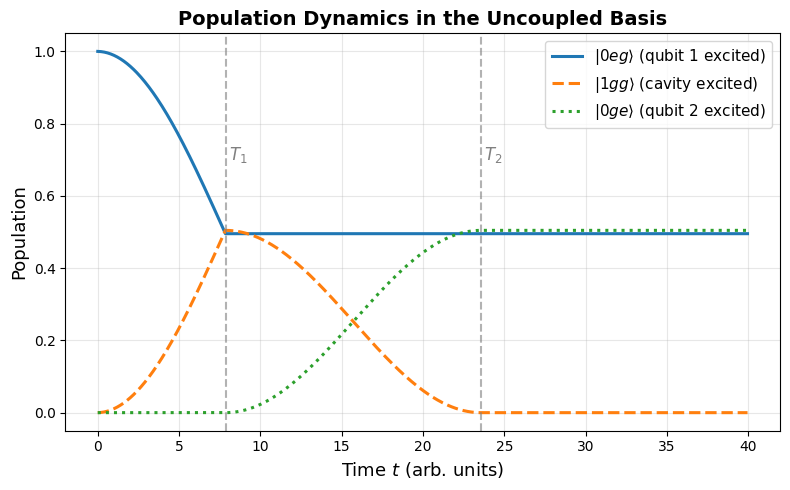

In [9]:
# 🎨 Step: Visualize population dynamics during iSWAP evolution

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

# --- Plot populations for key states ---
plt.plot(t, pops_uncoupled[:, 2], '-',  lw=2.2, label=r"$|0eg\rangle$ (qubit 1 excited)")
plt.plot(t, pops_uncoupled[:, 4], '--', lw=2.2, label=r"$|1gg\rangle$ (cavity excited)")
plt.plot(t, pops_uncoupled[:, 1], ':',  lw=2.2, label=r"$|0ge\rangle$ (qubit 2 excited)")

# --- Aesthetic settings ---
plt.xlabel(r"Time $t$ (arb. units)", fontsize=13)
plt.ylabel(r"Population", fontsize=13)
plt.title("Population Dynamics in the Uncoupled Basis", fontsize=14, weight='bold')
plt.grid(alpha=0.3)
plt.legend(fontsize=11, loc="upper right", frameon=True)
plt.tight_layout()

# --- Optional: mark the gate switching points ---
plt.axvline(x=T1_time, color='gray', linestyle='--', alpha=0.6)
plt.text(T1_time + 0.2, 0.7, r"$T_1$", fontsize=12, color='gray')
plt.axvline(x=T1_time+ T2_time, color='gray', linestyle='--', alpha=0.6)
plt.text(T1_time + T2_time + 0.2, 0.7, r"$T_2$", fontsize=12, color='gray')

# --- Show the result ---
plt.show()


## 🎯 Step: Comparing to the Target Bell State

At the end of our simulation, the system should ideally reach an **entangled Bell state** 
between the two molecular qubits while the cavity returns to its ground state.

$$
|\Psi\rangle = 
\frac{1}{\sqrt{2}}
\left( 
|g\rangle_1 |e\rangle_2 - |e\rangle_1 |g\rangle_2
\right)
$$

Since the cavity should end in $|0\rangle$, the full tripartite state is:

$$
|\Psi\rangle = 
\frac{1}{\sqrt{2}}
\left( 
|0\rangle |g\rangle |e\rangle 
- 
|0\rangle |e\rangle |g\rangle
\right)
$$

This is the **antisymmetric (singlet-like) Bell state**, which should result 
if the excitation transfer via the cavity performs an ideal *iSWAP* operation.

---

### 💭 Reflection Question
- What does it mean physically if the final fidelity is less than 1?  
- Which factors in our model (timing, coupling, truncation, etc.) might cause deviations from the perfect Bell state?

<details>
<summary><strong>Hint</strong></summary>
Remember: in this protocol, the cavity acts as a **quantum bus**.  
If it doesn’t fully return to $|0\rangl$, or if the timings $T_1, T_2$ aren’t perfectly tuned,  
you’ll lose coherence and the Bell state fidelity will drop.
</details>


In [10]:
# 🧮 Step: Compute fidelity with the target Bell state

from scipy import linalg as la

# --- ✏️ TODO 1: Construct the target Bell state |Ψ> ---
# 💡 Hint: It’s the antisymmetric superposition of |0ge> and |0eg>.
target_ket = np.sqrt(1/2) * ( np.kron(z_ket, np.kron(g_ket, e_ket)) - np.kron(z_ket, np.kron(e_ket, g_ket)))

# --- ✏️ TODO 2: Form the corresponding density matrix ρ_target = |Ψ⟩⟨Ψ| ---
target_rho = target_ket @ target_ket.conj().T

# --- Inspect both final and target density matrices ---
print("\nFinal density matrix (ρ_final):")
print(np.array2string(rho_new, formatter={'all': complex_formatter}))

print("\nTarget density matrix (ρ_target):")
print(np.array2string(target_rho, formatter={'all': complex_formatter}))

# --- ✏️ TODO 3: Compute fidelity using the Uhlmann formula ---
# 💡 Hint: Fidelity F(ρ, σ) = [Tr(√(√ρ σ √ρ))]^2
# fidelity = np.real(np.trace(...))**2

# --- Display result ---
#print(f"\n🔹 Fidelity with target Bell state: {fidelity:.6f}")

# 🧭 Optional check:
# If the fidelity is close to 1 → ideal iSWAP achieved!
# If it’s noticeably lower → consider timing or truncation effects.



Final density matrix (ρ_final):
[[ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.50 -0.50  0.00  0.00  0.00  0.00  0.00]
 [ 0.00 -0.50  0.50  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]]

Target density matrix (ρ_target):
[[ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.50 -0.50  0.00  0.00  0.00  0.00  0.00]
 [ 0.00 -0.50  0.50  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]]
